# Introduction

On this page, our attention turns to the implementation of Decision Trees and Random Forest using the same NCAA shot data from the 2021-22 Villanova season that was utilized in the clustering and dimensionality reduction tabs. We'll start by loading relevant libraries and reading in the data.

In [2]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read in the data
df = pd.read_csv('./data/modified_data/nova_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shot_value             2764 non-null   int64  
 1   field_goal_percentage  2764 non-null   float64
 2   lag1                   2764 non-null   float64
 3   home_crowd             2764 non-null   int64  
 4   score_diff             2764 non-null   int64  
 5   game_num               2764 non-null   int64  
 6   shot_outcome_numeric   2764 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 151.3 KB


# Baseline Comparisons

Let's start by examining the distribution of class labels, specifically distinguishing between made and missed shots:

In [3]:
# Compute the distribution of class labels
class_distribution = df['shot_outcome_numeric'].value_counts()

# Print the distribution
print("Class Distribution:")
print(class_distribution)

Class Distribution:
1    1448
0    1316
Name: shot_outcome_numeric, dtype: int64


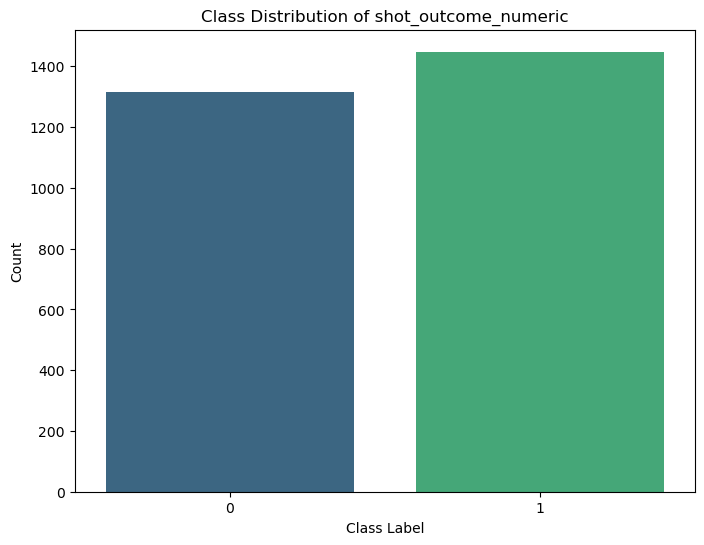

In [4]:
# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='shot_outcome_numeric', data=df, palette='viridis')
plt.title('Class Distribution of shot_outcome_numeric')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

There is a slight imbalance in class distribution for the shot_outcome_numeric target variable (class label). There are 1448 instances of 'made shot' (Class Label '1') and 1316 instances of 'missed shot' (Class Label '0'). This class imbalance can influence the performance of the classification model. It's essential to consider metrics beyond accuracy, such as precision and recall of the data, to gain a comprehensive understanding. Additionally, it's worth noting that a model predicting '1' for every instance would achieve 52.4% accuracy, so any model with an accuracy below this threshold does not provide meaningful predictions. Below is code that runs a random classifier on the data to see if it can beat the 52.4% accuracy threshold.

In [5]:
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Random Classifier function
def random_classifier(y_data):
    ypred = np.random.randint(2, size=len(y_data))  # Random predictions (0 or 1)
    
    print("-----RANDOM CLASSIFIER-----")
    print("Count of Predictions:", Counter(ypred).values())
    print("Probability of Predictions:", np.fromiter(Counter(ypred).values(), dtype=float) / len(y_data))
    
    accuracy = accuracy_score(y_data, ypred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_data, ypred)
    
    print("Accuracy:", accuracy)
    print("Precision (Class 0, Class 1):", precision)
    print("Recall (Class 0, Class 1):", recall)
    print("F1-score (Class 0, Class 1):", fscore)

# Using the 'shot_outcome_numeric' column as labels
y = df['shot_outcome_numeric']

# Running the random classifier
random_classifier(y)

-----RANDOM CLASSIFIER-----
Count of Predictions: dict_values([1357, 1407])
Probability of Predictions: [0.49095514 0.50904486]
Accuracy: 0.5032561505065123
Precision (Class 0, Class 1): [0.47974414 0.52763449]
Recall (Class 0, Class 1): [0.51291793 0.49447514]
F1-score (Class 0, Class 1): [0.49577672 0.51051693]


The random classifier acts as a rudimentary model that makes predictions through random guessing. Its primary role is to provide a fundamental benchmark for assessing the efficacy of more sophisticated models. Specifically applied to predicting basketball shot outcomes, this classifier yields an accuracy of approximately 50%, falling short of consistently predicting '1' (as established earlier). When evaluating advanced models, the goal is for them to surpass this random guessing baseline (and the 52.4% baseline from always guessing the most common class), demonstrating their ability to discern meaningful patterns within the data.

# Decision Tree

### Theory

Decision Trees are powerful machine learning algorithms used for classification and regression tasks, providing a hierarchical structure whereby nodes represent decisions based on specific features. The dataset is recursively split at decision nodes using criteria like Gini impurity for classification. Each leaf node corresponds to a class label in classification or a numerical value in regression, making the final predictions.
<br></br>
The simplicity and interpretability of Decision Trees make them widely applicable, but their susceptibility to overfitting necessitates techniques like pruning. Pruning involves removing non-contributive parts of the tree. Decision Trees offer insights into feature importance, with features near the top of the tree contributing more to predictive power.
<br></br>
Applying Decision Trees to real-world scenarios involves defining rules for classification based on the dataset's features. These rules provide a transparent decision-making process, making Decision Trees particularly useful for explaining predictions to non-experts. In the context of the basketball data I have been using, Decision Trees could form rules like "if the shot value is less than 2, classify it as a made shot." Feature selection and hyperparameter tuning further refine these trees to better fit the data, exemplifying their adaptability to various applications. The Gini Index is a common measure used in Decision Trees to determine optimal splits, minimizing impurity and enhancing predictive accuracy. Despite their advantages, Decision Trees' potential overfitting is mitigated by minimizing the number of layers or employing advanced techniques.

### Implementation

In the following code, we begin by importing the necessary libraries. Subsequently, we partition the data into subsets, distinguishing features and the target variable. Further, we perform another split on the data into training and test sets, allowing us to train a Decision Tree model on the training data and assess its performance using the test data. We then print the accuracy value of this model on the test data.

In [6]:
# laod in relevant libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

# split data in features and target variable
feature_columns = ['shot_value', 'field_goal_percentage', 'lag1', 'home_crowd', 'score_diff', 'game_num']
X = df[feature_columns].copy()

target_column = ['shot_outcome_numeric']
Y = df[target_column].copy()

# Split data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
model = DecisionTreeClassifier()

# Train Decision Tree Classifer
moodel = model.fit(X_train,Y_train)

#Predict the response for test dataset
Y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.5590361445783133


This decision tree did better than both baseline comparisons (both the random classifier and always guessing the most common class label). However, it is still not a great model; the accuracy only slightly improved to 56%. Let's visualize the model below.

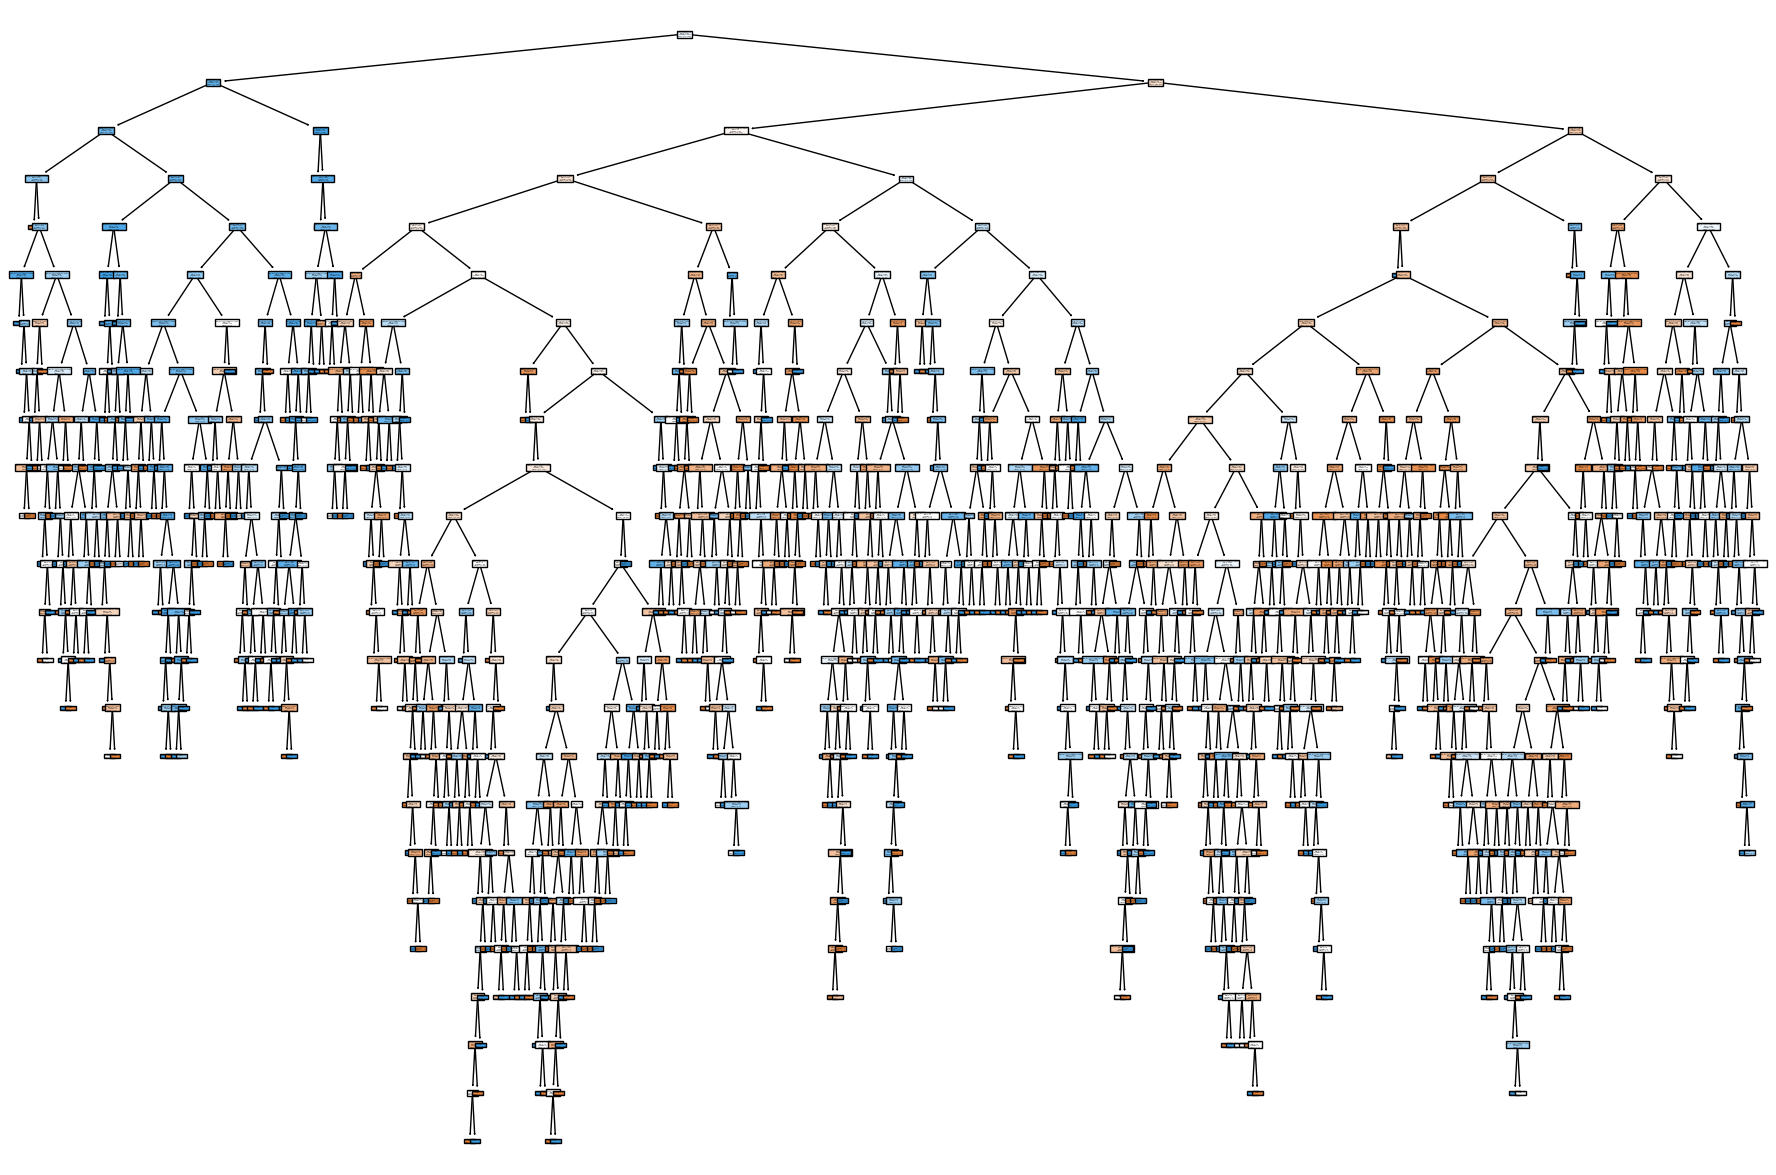

In [7]:
from sklearn.tree import plot_tree

def custom_plot_tree(model, X, Y):
    plt.figure(figsize=(22.5, 15))
    plot_tree(model, feature_names=X.columns, filled=True)
    plt.show()

custom_plot_tree(model, X_train, Y_train)

The initial decision tree above seems excessively large, indicating potential overfitting to the data. To address this, we'll adjust the hyperparameters below.

### Hyper-Parameter Tuning

The provided code iterates through different values for the hyperparameter (number of layers) and generates three plots to visualize the model's performance. The plots show the accuracy and recall for both training and test datasets, with varying numbers of layers in the Decision Tree (controlled by the max_depth hyperparameter). The blue lines represent training results, while the red lines depict test results.

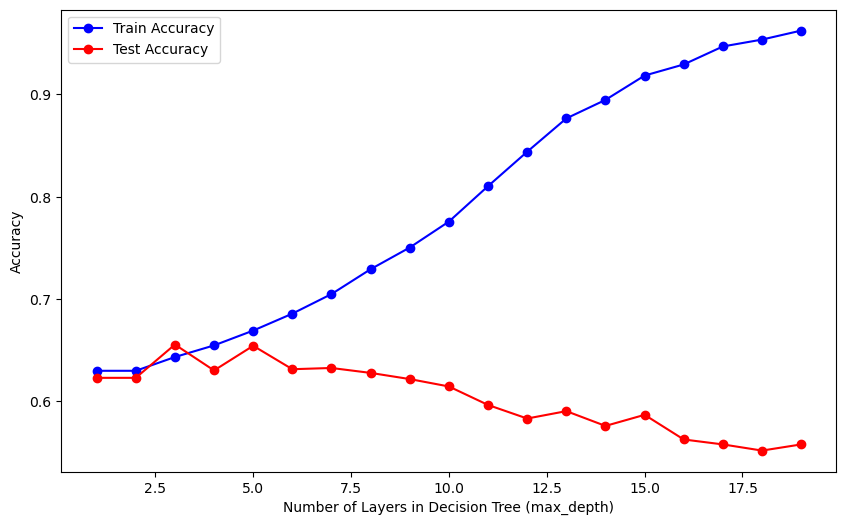

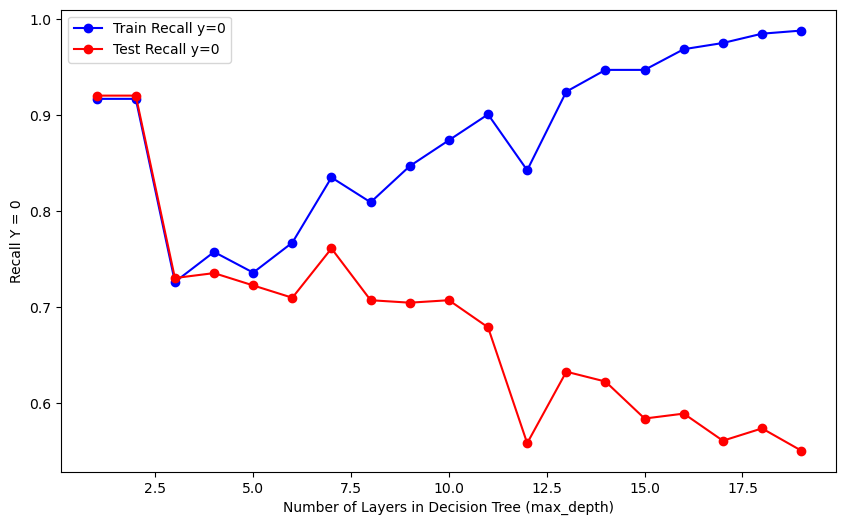

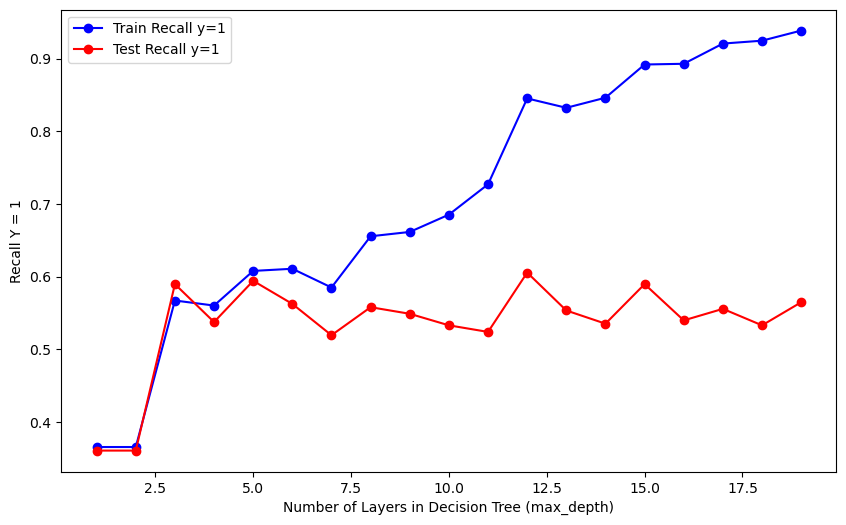

In [8]:
from sklearn.metrics import accuracy_score, recall_score

test_results=[]
train_results=[]

for num_layer in range(1,20):
    model = DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(X_train, Y_train)

    yp_train=model.predict(X_train)
    yp_test=model.predict(X_test)

    # print(y_pred.shape)
    test_results.append([num_layer,accuracy_score(Y_test, yp_test),recall_score(Y_test, yp_test,pos_label=0),recall_score(Y_test, yp_test,pos_label=1)])
    train_results.append([num_layer,accuracy_score(Y_train, yp_train),recall_score(Y_train, yp_train,pos_label=0),recall_score(Y_train, yp_train,pos_label=1)])

# Extracting data
num_layers = [result[0] for result in test_results]
train_accuracy_values = [result[1] for result in train_results]
test_accuracy_values = [result[1] for result in test_results]
train_recall_0_values = [result[2] for result in train_results]
test_recall_0_values = [result[2] for result in test_results]
train_recall_1_values = [result[3] for result in train_results]
test_recall_1_values = [result[3] for result in test_results]

# Accuracy
plt.figure(figsize=(10, 6))
plt.plot(num_layers, train_accuracy_values, label='Train Accuracy', marker='o', color='blue')
plt.plot(num_layers, test_accuracy_values, label='Test Accuracy', marker='o', color='red')
plt.xlabel('Number of Layers in Decision Tree (max_depth)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Recall Y = 0
plt.figure(figsize=(10, 6))
plt.plot(num_layers, train_recall_0_values, label='Train Recall y=0', marker='o', color='blue')
plt.plot(num_layers, test_recall_0_values, label='Test Recall y=0', marker='o', color='red')
plt.xlabel('Number of Layers in Decision Tree (max_depth)')
plt.ylabel('Recall Y = 0')
plt.legend()
plt.show()

# Recall Y = 1
plt.figure(figsize=(10, 6))
plt.plot(num_layers, train_recall_1_values, label='Train Recall y=1', marker='o', color='blue')
plt.plot(num_layers, test_recall_1_values, label='Test Recall y=1', marker='o', color='red')
plt.xlabel('Number of Layers in Decision Tree (max_depth)')
plt.ylabel('Recall Y = 1')
plt.legend()
plt.show()

### Training Optimal Model

Based on the graphs, it appears that an optimal model would have three layers (a depth of 3). Consequently, we will re-train the decision tree using this optimal hyperparameter obtained from the plot above in the code below. Additionally, in the code chunk we will define and use a function that generates a confusion matrix plot, display metrics, and decision tree. 

ACCURACY: 0.655421686746988
NEGATIVE RECALL (Y=0): 0.7300771208226221
NEGATIVE PRECISION (Y=0): 0.610752688172043
POSITIVE RECALL (Y=1): 0.5895691609977324
POSITIVE PRECISION (Y=1): 0.7123287671232876
[[284 105]
 [181 260]]


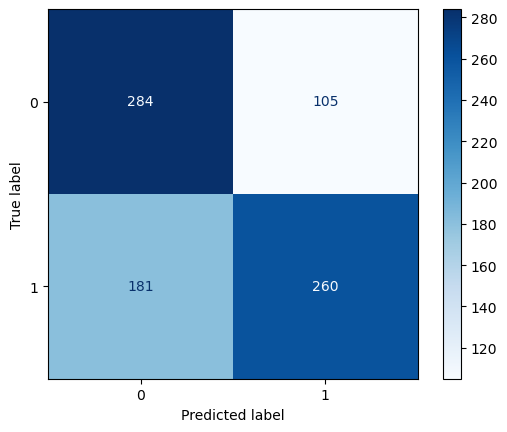

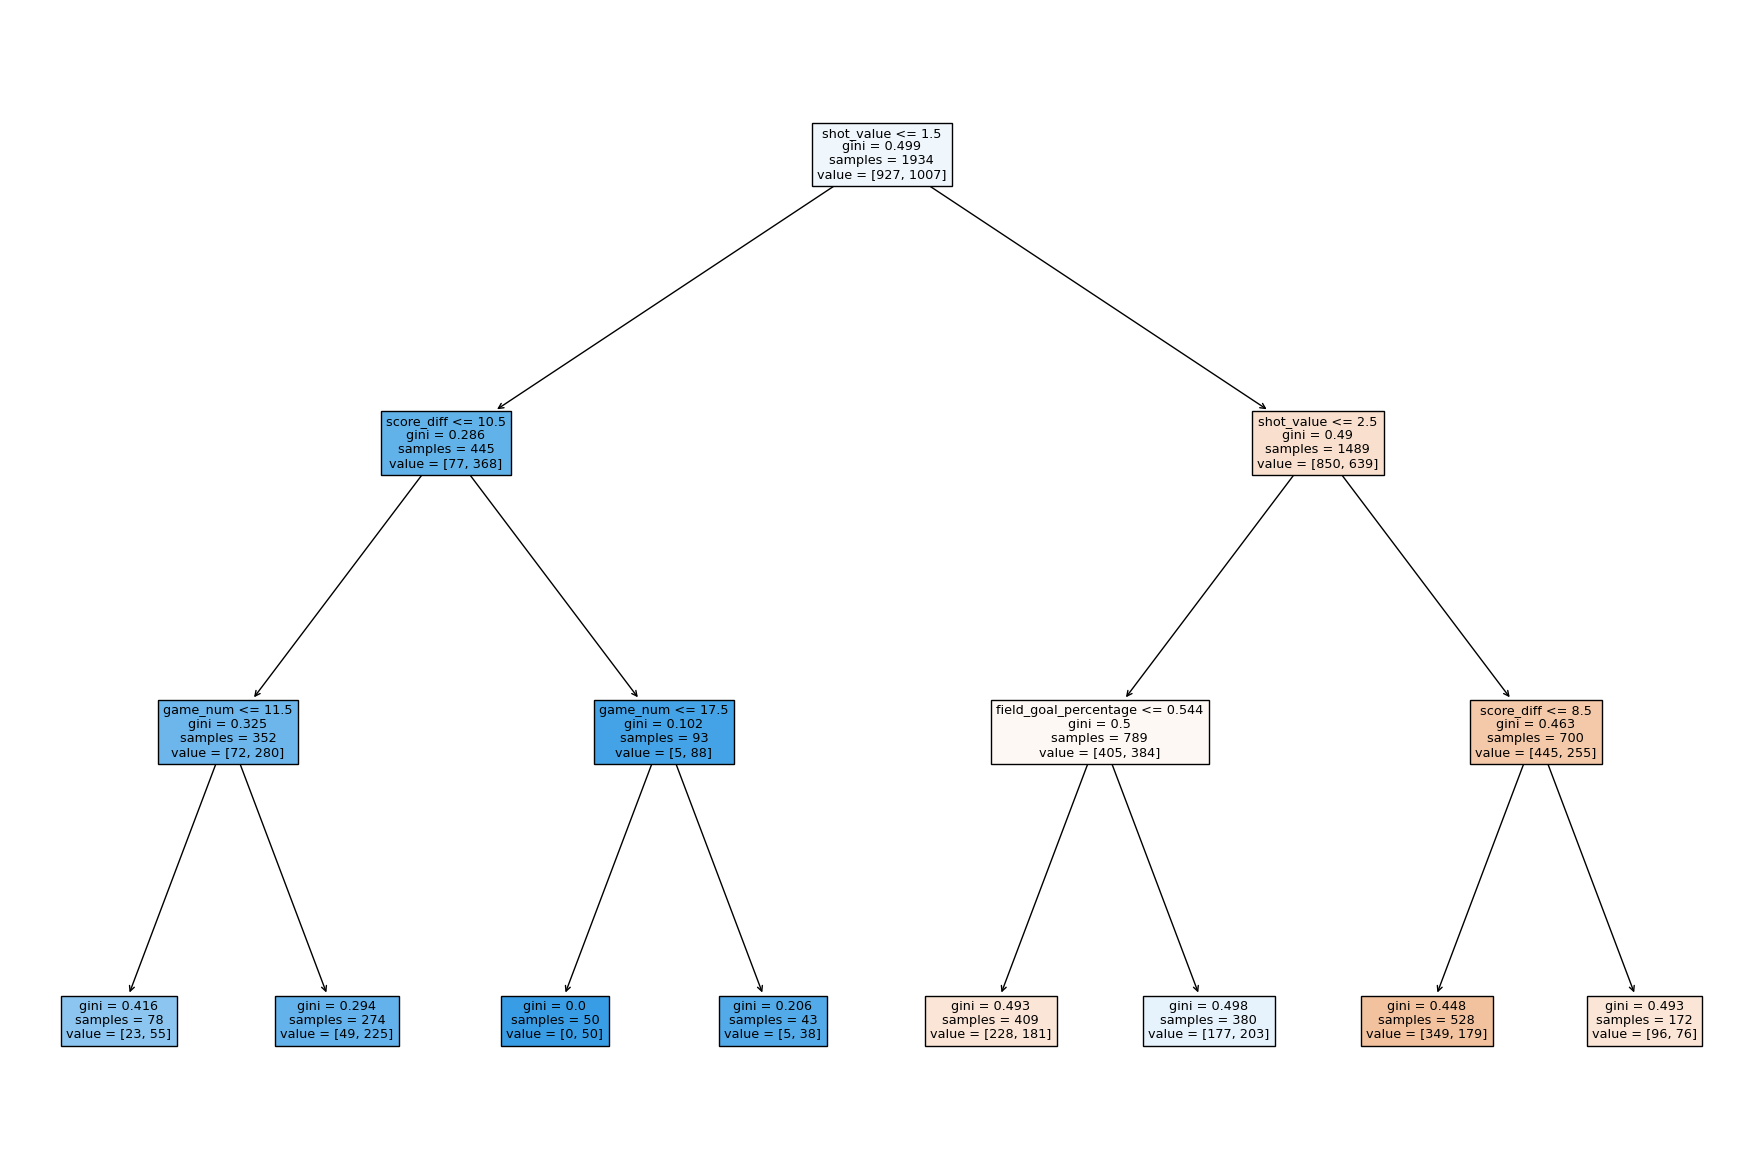

In [9]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=3)
model = model.fit(X_train, Y_train)

yp_train=model.predict(X_train)
yp_test=model.predict(X_test)

#function which generates a confusion matrix plot and prints information
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_plot(y_true, y_pred):
    # metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    # plot
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    matrix.plot(cmap=plt.cm.Blues)

    # formatting
    print(f"ACCURACY: {accuracy}")
    print(f"NEGATIVE RECALL (Y=0): {recall[0]}")
    print(f"NEGATIVE PRECISION (Y=0): {precision[0]}")
    print(f"POSITIVE RECALL (Y=1): {recall[1]}")
    print(f"POSITIVE PRECISION (Y=1): {precision[1]}")
    print(cm)

confusion_plot(Y_test,yp_test)
plt.show()
custom_plot_tree(model,X,Y)

In [10]:
tree_summary = tree.export_text(model, feature_names=X_train.columns.tolist())
print(tree_summary)

|--- shot_value <= 1.50
|   |--- score_diff <= 10.50
|   |   |--- game_num <= 11.50
|   |   |   |--- class: 1
|   |   |--- game_num >  11.50
|   |   |   |--- class: 1
|   |--- score_diff >  10.50
|   |   |--- game_num <= 17.50
|   |   |   |--- class: 1
|   |   |--- game_num >  17.50
|   |   |   |--- class: 1
|--- shot_value >  1.50
|   |--- shot_value <= 2.50
|   |   |--- field_goal_percentage <= 0.54
|   |   |   |--- class: 0
|   |   |--- field_goal_percentage >  0.54
|   |   |   |--- class: 1
|   |--- shot_value >  2.50
|   |   |--- score_diff <= 8.50
|   |   |   |--- class: 0
|   |   |--- score_diff >  8.50
|   |   |   |--- class: 0



### Conclusion
After tuning the hyperparameter, the model's accuracy improved to 65.5%, marking a notable 13% enhancement compared to the baseline and a 9.5% improvement over the untuned version. Delving into the confusion matrix, it becomes evident that the model accurately predicted made shots (class 1) in 71.2% of cases, while achieving a 61.1% accuracy in identifying missed shots (class 0). This nuanced evaluation provides insights into the model's strengths and areas for potential refinement. Notably, the absence of the 'lag' variable in the decision tree suggests its limited influence on the model, aligning with the initial hypothesis of its lower predictive power.

In summary, the hyperparameter-tuned decision tree exhibits improved accuracy and provides valuable insights into feature importance. The visualization underscores the significance of 'shot_value' and 'field_goal_percentage' in predicting shot outcomes, while the negligible role of the 'lag' variable aligns with expectations, emphasizing the model's capacity to discern key predictors in the dataset.

# Random Forest

<i><b>Disclaimer:</b></i> Although the preceding code and analysis successfully meet the assignment requirements, I also wanted to explore the application of random forests. This section will be more concise, but includes the necessary code and some analysis for random forests.

### Theory

A random forest differs from a single decision tree in that it is an ensemble or a collection of decision trees. Instead of relying on the prediction of a single tree, a random forest aggregates the predictions of multiple trees to make a more robust and accurate prediction. Every tree in the 'random forest' is trained on a random subset of the data and features, introducing diversity in the models. During predictions, the random forest averages or takes a vote of the individual tree predictions, reducing the risk of overfitting and improving generalization performance. This ensemble approach makes random forests particularly effective in handling complex datasets and enhancing the stability and reliability of the overall model.

### Implementation

The following code imports necessary libraries, splits the data into training and test sets, creates a Random Forest Classifier model, trains it on the training data, predicts outcomes on the test data, and then prints the accuracy of the model's predictions.

In [32]:
# load relevant libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Create the model
model = RandomForestClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6365280289330922


/var/folders/lb/dk54cbx965z7nj61zps2fzr00000gn/T/ipykernel_50519/4200927063.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)


We can see that without any tuning, the random forest almost matches the accuracy of the hyperparameter-tuned decision tree. Let's visualize the first three trees in the random forest below.

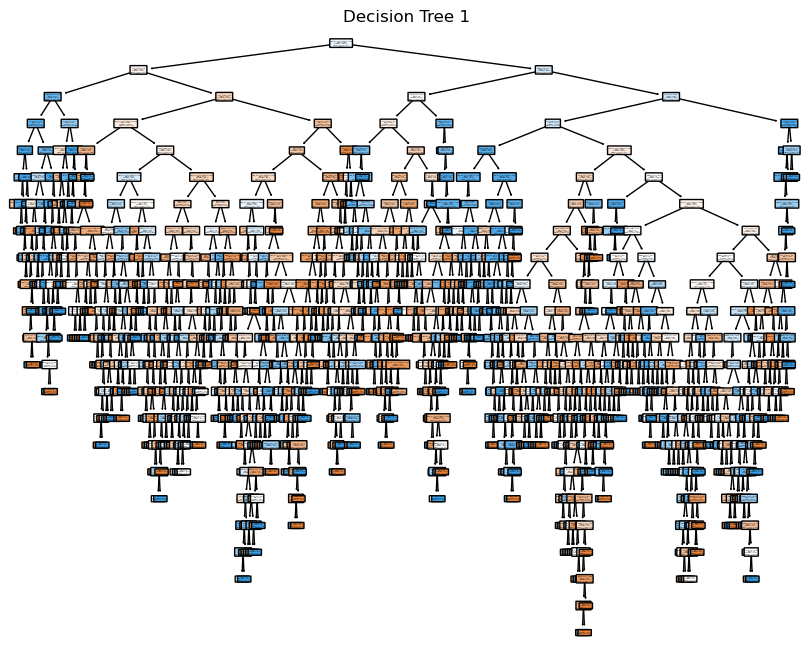

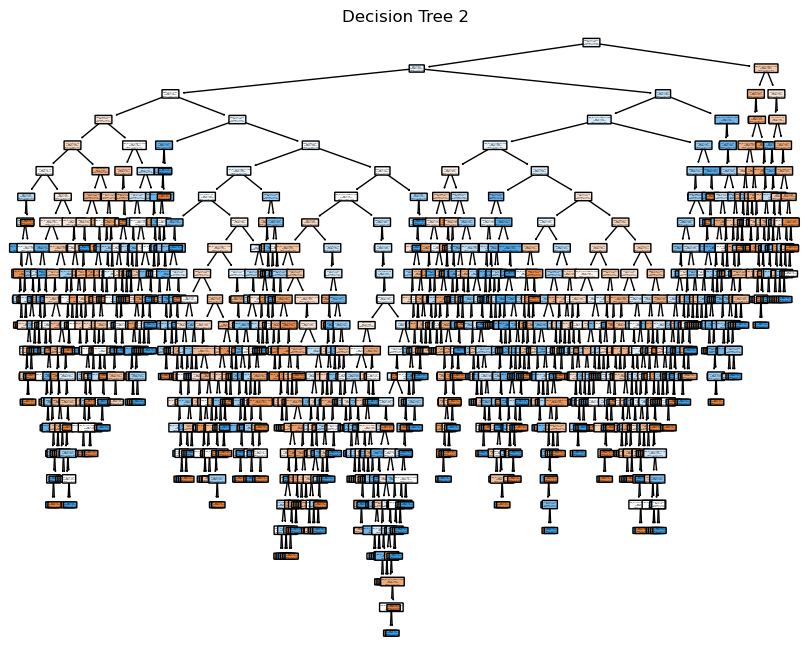

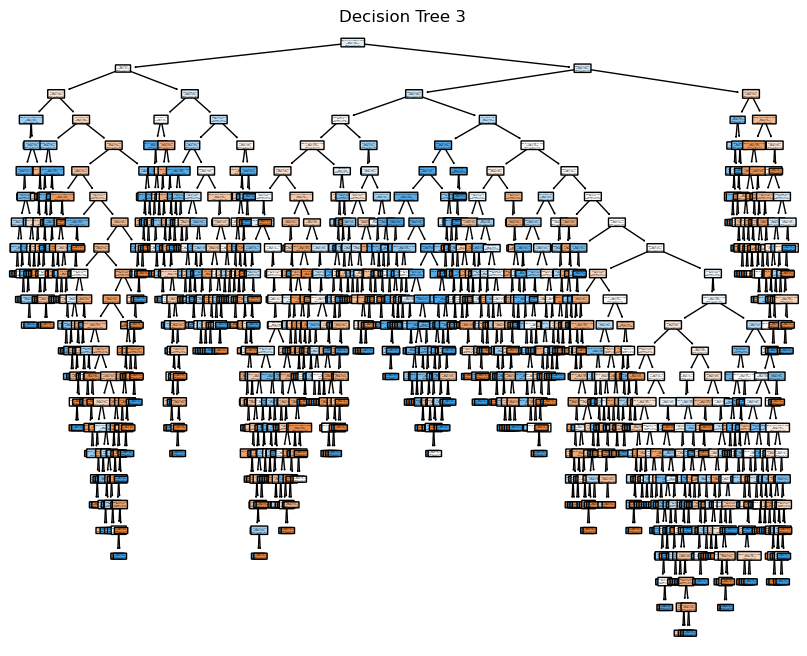

In [33]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = model.estimators_[i]

    # Plot the tree
    plt.figure(figsize=(10, 8))
    plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=['0', '1'], rounded=True, proportion=True)
    plt.title(f'Decision Tree {i + 1}')
    plt.show()

### Hyper-Parameter Tuning
Next, we will utilize a random search with cross-validation to find the best hyperparameters within a specified range. The best model is then stored, and the optimal hyperparameters are printed.

In [34]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Convert Y_train to a one-dimensional array
Y_train = Y_train.values.ravel()

# Create a random forest classifier
model = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 417}


### Training Optimal Model
Using the above hyperparameters, let's train the optimal random forest model.

In [35]:
# Predictions on the test set
yp_test = best_rf.predict(X_test)

ACCURACY: 0.6672694394213382
NEGATIVE RECALL (Y=0): 0.861003861003861
NEGATIVE PRECISION (Y=0): 0.601078167115903
POSITIVE RECALL (Y=1): 0.4965986394557823
POSITIVE PRECISION (Y=1): 0.8021978021978022
[[223  36]
 [148 146]]


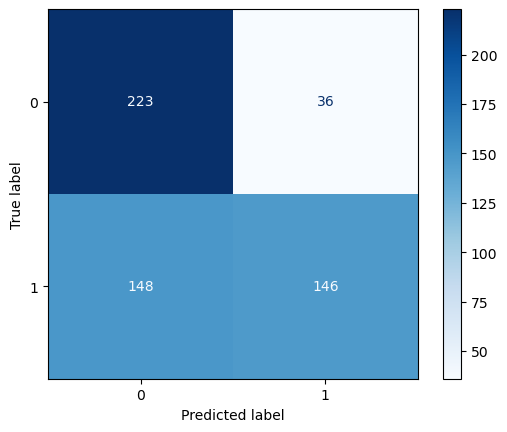

In [36]:
confusion_plot(Y_test, yp_test)

<Axes: >

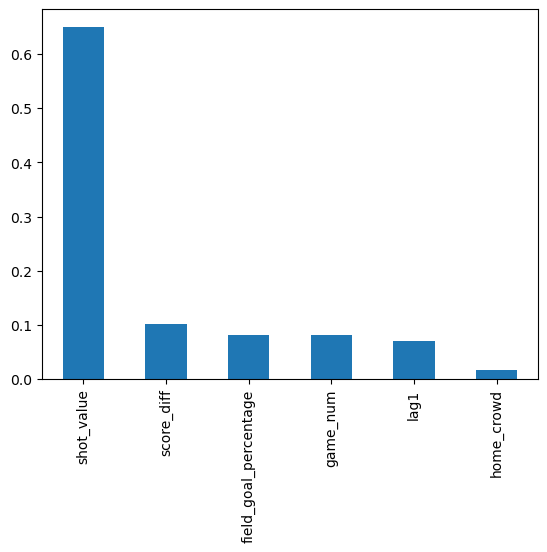

In [37]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# bar chart
feature_importances.plot.bar()

### Conclusion

The tuned Random Forest model exhibits improved accuracy compared to the tuned Decision Tree, achieving an accuracy of 66.7%. Notably, the Random Forest model demonstrates higher positive recall (Y=1) and precision, indicating enhanced performance in correctly identifying instances of made shots. 

The above code calculates the feature importance from the tuned Random Forest model and creates a bar chart to visualize the importance of each feature in predicting shot outcomes. The resulting chart helps identify which features have the most significant impact on the model's decision-making process. The bar chart reveals, expectedly, that shot value has the most significant impact by a large margin. At the same time, lag1 exhibits a meager impact, aligning with similar results from the tuned decision tree.

# Extra Joke
Which dating app do trees use?  
Timber
<br></br>
![](./images/tree.gif)